In [1]:
import sys
sys.path.append('../../astro_tools')
import axes_offset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
from scipy.integrate import quad


# set up the plot
import cmasher as cmr
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 25,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the standard normal distribution function (PDF)
def gaussian(x, amp, mean, sig):
    return amp * (1 / (sig * np.sqrt(2 * np.pi))) * np.exp(-((x - mean)**2) / (2 * sig**2))


# def get_fluxes(amp,mean,sig,lower_lim, upper_lim):

#     # numerical integration using Gaussian quadrature
#     fluxes, _ = quad(gaussian, lower_limit, upper_limit, args=(amp,mean,sig))

#     return fluxes

def line_flux(amp, sig):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    flux = amp * sig * np.sqrt(2*np.pi)
#     flux_err = flux*np.sqrt((peak_err/peak)**2 + (width_err/width)**2)
    return flux


def get_data(line,param,comp):
    
    """
    line must be ha, niia, niib, siia, or siib
    param must be amp, vel, or sigma
    comp must be outflow_blue, outflow_red, or disk
    
    """
    
    file = '../../ngc253/muse/data/output_maps/ngc253_muse_se_%s_%s_%s.fits' % (line, param, comp)
    
    hdu = fits.open(file)
    hdu_data = hdu[0].data
    
    return(hdu_data)


def make_plots(outb_dat, outr_dat, disk_dat, vmin, vmax, line_label, cbar_label):
        
    cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

    # BLUESHIFTED OUTFLOW
    im = ax1.imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax1.set_title('Outflow B', fontsize=24)
    ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax1.set_facecolor('black')
    ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
    ax1.set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax1.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)

    # REDSHIFTED OUTFLOW
    im = ax2.imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax2.set_title('Outflow R', fontsize=24)
    ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax2.set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax2.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax2.add_artist(at)

    # DISK
    im = ax3.imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    ax3.set_title('Disk', fontsize=24)
    ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
    ax3.set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax3.add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax3.add_artist(at)

    cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=ax3, cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

    fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.3, hspace=0)
    plt.show()
    
    return


def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label):
        
    cmap = cmr.get_sub_cmap('cmr.tropical_r', 0.1, 0.90)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')
    
    return

In [3]:
# grab files, including the original
# get info of original data
og = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
w = wcs.WCS(hdu.header, naxis=2).celestial

ha_amp_disk = get_data(line='ha', param='amp', comp='disk')
ha_vel_disk = get_data(line='ha', param='vel', comp='disk')
ha_sig_disk = get_data(line='ha', param='sig', comp='disk')
ha_amp_outb = get_data(line='ha', param='amp', comp='outflow_blue')
ha_vel_outb = get_data(line='ha', param='vel', comp='outflow_blue')
ha_sig_outb = get_data(line='ha', param='sig', comp='outflow_blue')
ha_amp_outr = get_data(line='ha', param='amp', comp='outflow_red')
ha_vel_outr = get_data(line='ha', param='vel', comp='outflow_red')
ha_sig_outr = get_data(line='ha', param='sig', comp='outflow_red')

niib_amp_disk = get_data(line='niib', param='amp', comp='disk')
niib_vel_disk = get_data(line='niib', param='vel', comp='disk')
niib_sig_disk = get_data(line='niib', param='sig', comp='disk')
niib_amp_outb = get_data(line='niib', param='amp', comp='outflow_blue')
niib_vel_outb = get_data(line='niib', param='vel', comp='outflow_blue')
niib_sig_outb = get_data(line='niib', param='sig', comp='outflow_blue')
niib_amp_outr = get_data(line='niib', param='amp', comp='outflow_red')
niib_vel_outr = get_data(line='niib', param='vel', comp='outflow_red')
niib_sig_outr = get_data(line='niib', param='sig', comp='outflow_red')

siib_amp_disk = get_data(line='siib', param='amp', comp='disk')
siib_vel_disk = get_data(line='siib', param='vel', comp='disk')
siib_sig_disk = get_data(line='siib', param='sig', comp='disk')
siib_amp_outb = get_data(line='siib', param='amp', comp='outflow_blue')
siib_vel_outb = get_data(line='siib', param='vel', comp='outflow_blue')
siib_sig_outb = get_data(line='siib', param='sig', comp='outflow_blue')
siib_amp_outr = get_data(line='siib', param='amp', comp='outflow_red')
siib_vel_outr = get_data(line='siib', param='vel', comp='outflow_red')
siib_sig_outr = get_data(line='siib', param='sig', comp='outflow_red')

siia_amp_disk = get_data(line='siia', param='amp', comp='disk')
siia_vel_disk = get_data(line='siia', param='vel', comp='disk')
siia_sig_disk = get_data(line='siia', param='sig', comp='disk')
siia_amp_outb = get_data(line='siia', param='amp', comp='outflow_blue')
siia_vel_outb = get_data(line='siia', param='vel', comp='outflow_blue')
siia_sig_outb = get_data(line='siia', param='sig', comp='outflow_blue')
siia_amp_outr = get_data(line='siia', param='amp', comp='outflow_red')
siia_vel_outr = get_data(line='siia', param='vel', comp='outflow_red')
siia_sig_outr = get_data(line='siia', param='sig', comp='outflow_red')

In [4]:
ha_flux_disk = line_flux(ha_amp_disk, ha_sig_disk)
ha_flux_outb = line_flux(ha_amp_outb, ha_sig_outb)
ha_flux_outr = line_flux(ha_amp_outr, ha_sig_outr)

niib_flux_disk = line_flux(niib_amp_disk, niib_sig_disk)
niib_flux_outb = line_flux(niib_amp_outb, niib_sig_outb)
niib_flux_outr = line_flux(niib_amp_outr, niib_sig_outr)

siia_flux_disk = line_flux(siia_amp_disk, siia_sig_disk)
siia_flux_outb = line_flux(siia_amp_outb, siia_sig_outb)
siia_flux_outr = line_flux(siia_amp_outr, siia_sig_outr)

siib_flux_disk = line_flux(siib_amp_disk, siib_sig_disk)
siib_flux_outb = line_flux(siib_amp_outb, siib_sig_outb)
siib_flux_outr = line_flux(siib_amp_outr, siib_sig_outr)

In [5]:
# take ratios
nii_disk_rat = np.log(niib_flux_disk / ha_flux_disk)
nii_outb_rat = np.log(niib_flux_outb / ha_flux_outb)
nii_outr_rat = np.log(niib_flux_outr / ha_flux_outr)

sii_disk_rat = np.log((siia_flux_disk + siib_flux_disk) / ha_flux_disk)
sii_outb_rat = np.log((siia_flux_outb + siib_flux_outb) / ha_flux_outb)
sii_outr_rat = np.log((siia_flux_outr + siib_flux_outr) / ha_flux_outr)

In [89]:
ra_hms, dec_dms = axes_offset.get_offset(ha_amp_disk, w)
pixscale = 0.2  # arcsec
x_lower = -(ha_amp_disk.shape[1]*pixscale)//2
x_upper = (ha_amp_disk.shape[1]*pixscale)//2
y_lower = -(ha_amp_disk.shape[0]*pixscale)//2
y_upper = (ha_amp_disk.shape[0]*pixscale)//2
extent=[x_lower,x_upper, y_lower,y_upper]

First plot the integrated fluxes.

In [90]:
# make_plots(np.log(ha_flux_outb * 10**-4), 
#            np.log(ha_flux_outr * 10**-4), 
#            np.log(ha_flux_disk * 10**-4),
#            vmin = 0,
#            vmax = 5,
#            line_label = 'H$\\alpha$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)', 
#            savepath = None)

# make_plots(np.log(niib_flux_outb * 10**-4), 
#            np.log(niib_flux_outr * 10**-4), 
#            np.log(niib_flux_disk * 10**-4),
#            vmin = 0,
#            vmax = 5,
#            line_label = '[N II]\n$\lambda6583.45$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)', 
#            savepath = None)

# make_plots(np.log((siia_flux_outb+siib_flux_outb) * 10**-4), 
#            np.log((siia_flux_outr+siib_flux_outb) * 10**-4), 
#            np.log((siia_flux_disk+siib_flux_outb) * 10**-4),
#            vmin = 0,
#            vmax = 5,
#            line_label = '[S II]\n$\lambda6716.44+\lambda6730.82$', 
#            cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)', 
#            savepath = None)

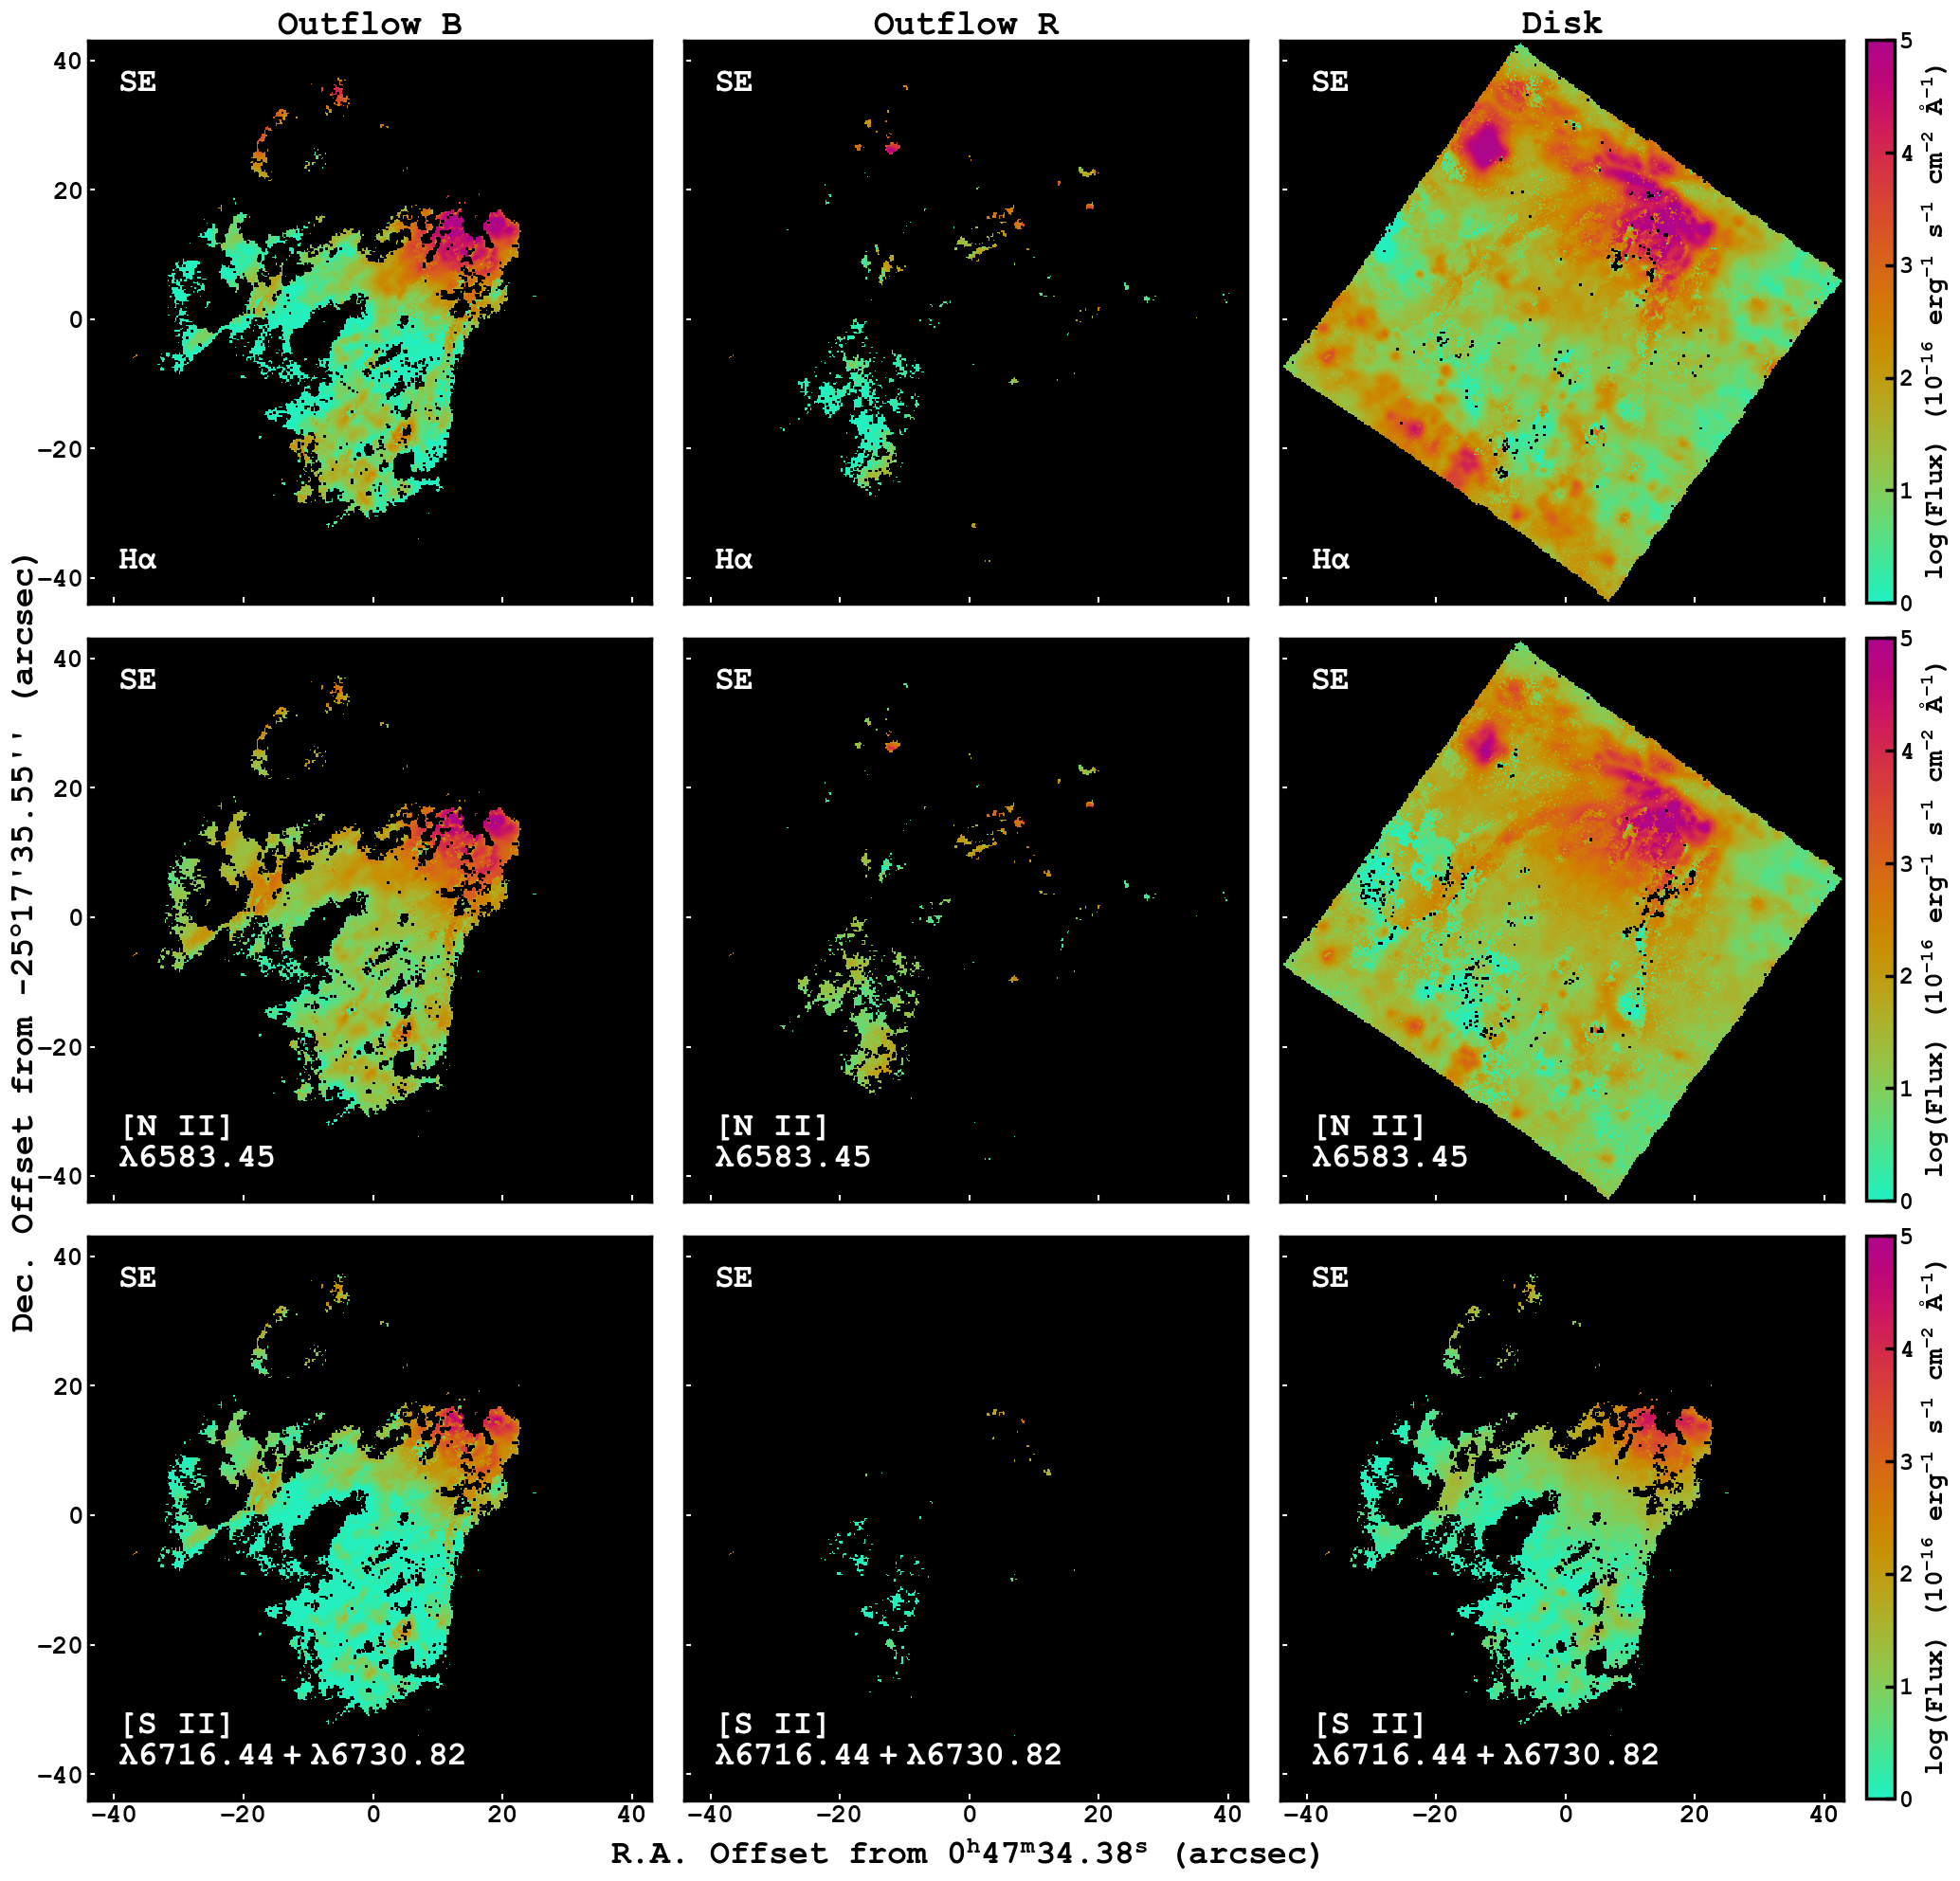

In [91]:
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6),
     (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(21, 20), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              np.log(ha_flux_outb * 10**-4),
              np.log(ha_flux_outr * 10**-4),
              np.log(ha_flux_disk * 10**-4),
              vmin = 0,
              vmax = 5,
              titles = True,
              line_label = 'H$\\alpha$',
              cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

make_big_plot([ax4, ax5, ax6],
              np.log(niib_flux_outb * 10**-4),
              np.log(niib_flux_outr * 10**-4),
              np.log(niib_flux_disk * 10**-4),
              vmin = 0,
              vmax = 5,
              titles = False,
              line_label = '[N II]\n$\lambda6583.45$',
              cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

make_big_plot([ax7, ax8, ax9],
              np.log((siia_flux_outb+siib_flux_outb) * 10**-4),
              np.log((siia_flux_outr+siib_flux_outb) * 10**-4),
              np.log((siia_flux_disk+siib_flux_outb) * 10**-4),
              vmin = 0,
              vmax = 5,
              titles = False,
              line_label = '[S II]\n$\lambda6716.44+\lambda6730.82$',
              cbar_label = 'log(Flux) (10$^{-16}$ erg$^{-1}$ s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$)')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()

plt.savefig('../../ngc253/muse/visuals/se_flux.png',bbox_inches='tight', dpi=200)
plt.show()

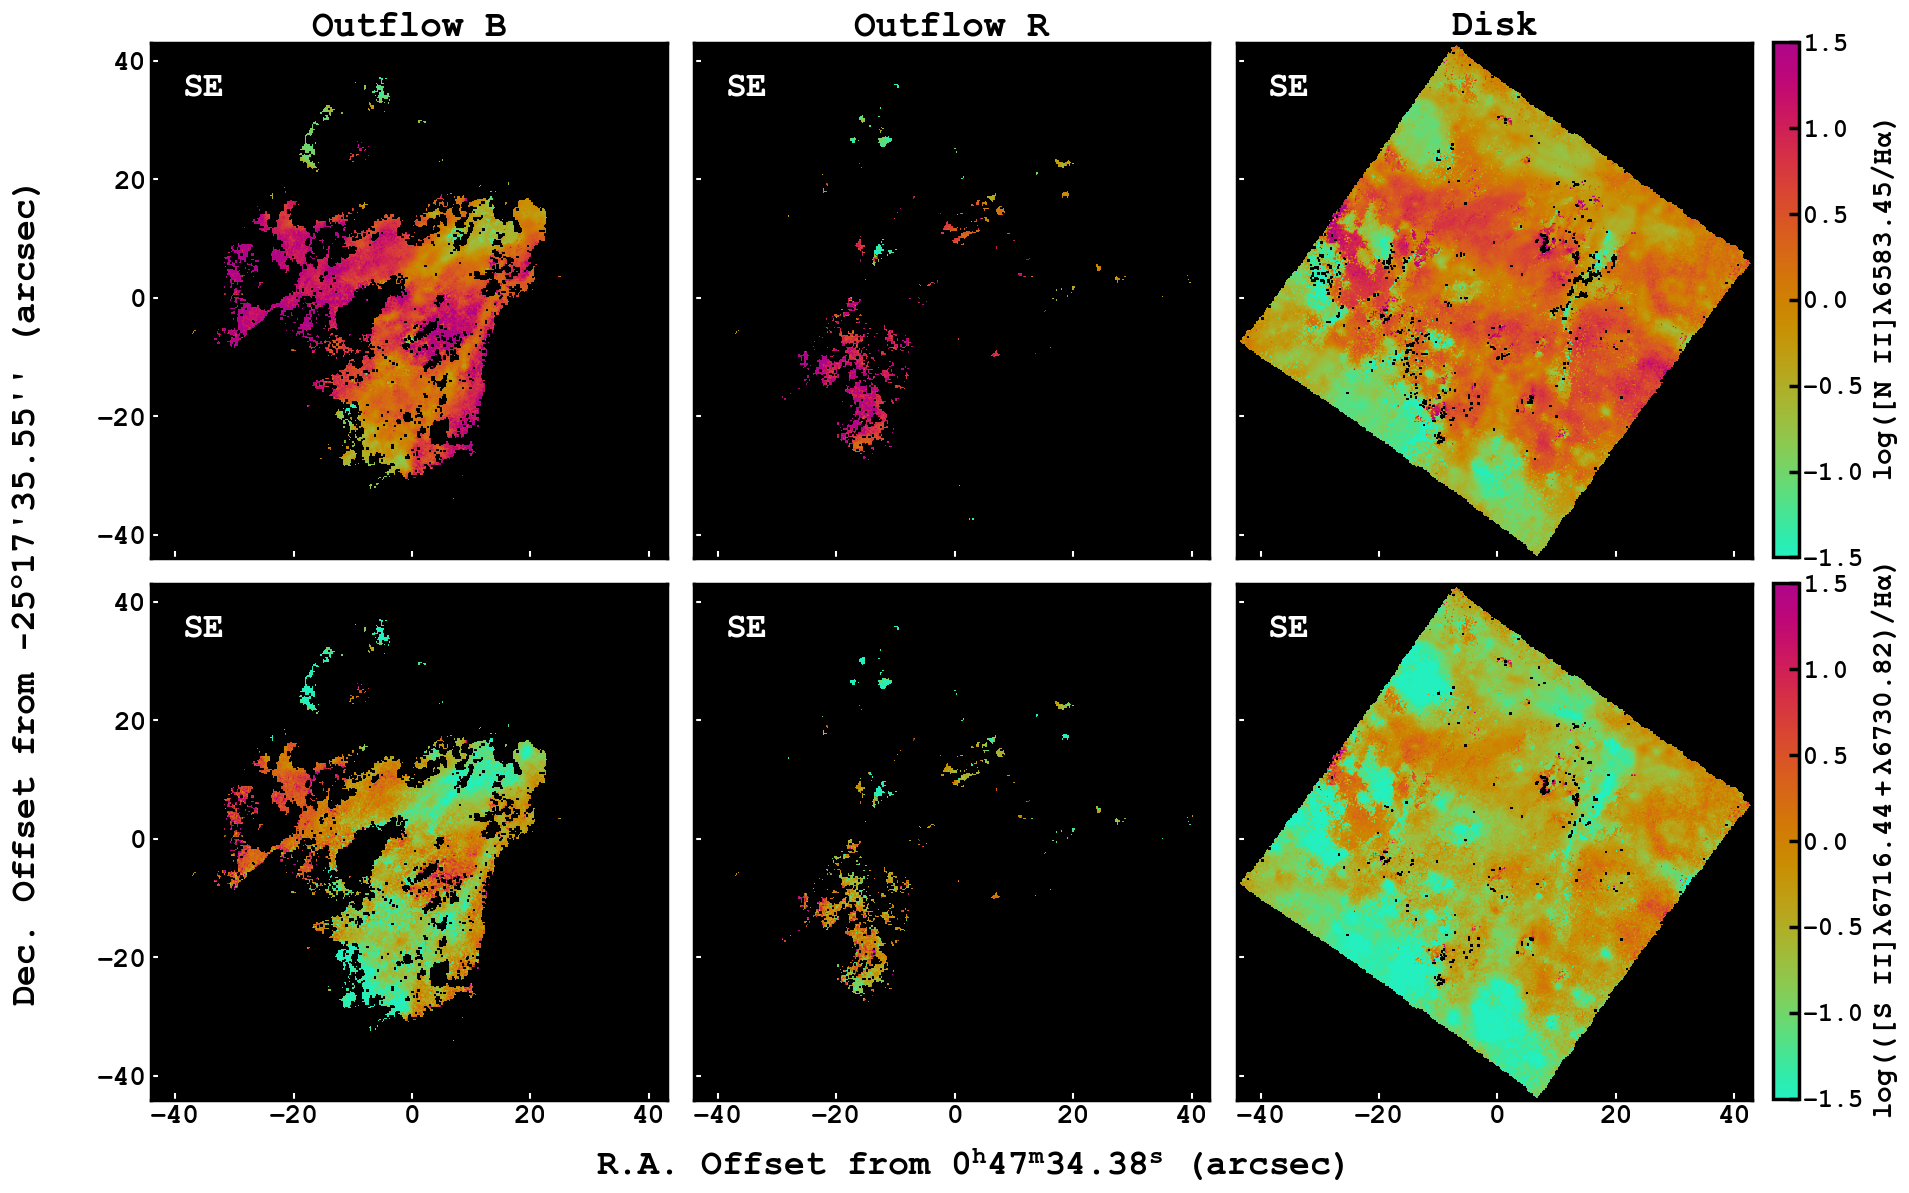

In [114]:
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              nii_outb_rat,
              nii_outr_rat,
              nii_disk_rat,
              vmin = -1.5,
              vmax = 1.5,
              titles = True,
              line_label = None,
              cbar_label = 'log([N II]$\lambda 6583.45$/H$\\alpha$)')

make_big_plot([ax4, ax5, ax6],
              sii_outb_rat,
              sii_outr_rat,
              sii_disk_rat,
              vmin = -1.5,
              vmax = 1.5,
              titles = False,
              line_label = None,
              cbar_label = 'log(([S II]$\lambda6716.44+\lambda6730.82$)/H$\\alpha$)')


fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,hspace=0.05)

plt.savefig('../../ngc253/muse/visuals/line_ratios.png',bbox_inches='tight', dpi=200)
plt.show()

In [22]:
def run_outb(siib_flux_outb,siia_flux_outb):
    print('running outflow b...')
    sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
    edens_outb = sii.getTemDen(sii_outb_flux_rat[100:110,100:110], tem=1e4, wave1=6730, wave2=6716)
    np.savetxt('../../ngc253/muse/data/edens_outb.txt', edens_outb)
    return edens_outb

def run_outr(siib_flux_outr,siia_flux_outr):
    print('running outflow r...')
    sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
    edens_outr = sii.getTemDen(sii_outr_flux_rat[100:110,100:110], tem=1e4, wave1=6730, wave2=6716)
    np.savetxt('../../ngc253/muse/data/edens_outr.txt', edens_outr)
    return edens_outr

def run_disk(siib_flux_disk,siia_flux_disk):
    print('running disk...')
    sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
    edens_disk = sii.getTemDen(sii_disk_flux_rat[100:110,100:110], tem=1e4, wave1=6730, wave2=6716)
    np.savetxt('../../ngc253/muse/data/edens_disk.txt', edens_disk)
    return edens_disk

In [30]:
from multiprocessing import Process
import sys
sys.path.append('../../astro_tools')
from calc_edens import run_outb, run_outr, run_disk

p1 = Process(target = run_outb, args=(siib_flux_outb,siia_flux_outb))
p1.start()
p2 = Process(target = run_outr, args=(siib_flux_outr,siia_flux_outr))
p2.start()
# p3 = Process(target = run_disk, args=(siib_flux_disk,siia_flux_disk))
# p3.start()

p1.join()
p2.join()
# p3.join()

/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py:7: RuntimeWarning: divide by zero encountered in divide
  sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py:7: RuntimeWarning: invalid value encountered in divide
  sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py:15: RuntimeWarning: divide by zero encountered in divide
  sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py:15: RuntimeWarning: invalid value encountered in divide
  sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py:23: RuntimeWarning: divide by zero encountered in divide
  sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
/Users/serenac/Desk

running outflow r...
running disk...
running outflow b...


Process Process-16:
Process Process-15:
Process Process-17:
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/ngc253_muse/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Applications/anaconda3/envs/ngc253_muse/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/serenac/Desktop/research/cavaliers/line_ratios/../../astro_tools/calc_edens.py", line 16, in run_outr
    edens_outr = sii.getTemDen(sii_outr_flux_rat, tem=1e4, wave1=6730, wave2=6716)
  File "/Applications/anaconda3/envs/ngc253_muse/lib/python3.10/site-packages/pyneb/core/pynebcore.py", line 2444, in getTemDen
    return self._getTemDen_1(int_ratio=int_ratio, tem=tem, den=den, lev_i1=lev_i1, lev_j1=lev_j1, lev_i2=lev_i2, lev_j2=lev_j2,
  File "/Applications/anaconda3/envs/ngc253_muse/lib/python3.10/site-packages/pyneb/core/pynebcore.py", line 2073, in _getTemDen_1
    result[i] = self._getTemDe

KeyboardInterrupt: 

In [13]:
import pyneb

# set up atoms
sii = pyneb.Atom('S',2)

print('running...')
sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
%time edens_outb = sii.getTemDen(sii_outb_flux_rat[100:110,100:110], tem=1e4, wave1=6730, wave2=6716)

running...
CPU times: user 3.17 s, sys: 13.1 ms, total: 3.18 s
Wall time: 3.25 s


In [14]:
%time edens_outb = sii.getTemDen(sii_outb_flux_rat[100:150,100:150], tem=1e4, wave1=6730, wave2=6716)


CPU times: user 1min 16s, sys: 207 ms, total: 1min 16s
Wall time: 1min 16s


In [15]:
%time edens_outb = sii.getTemDen(sii_outb_flux_rat[100:200,100:200], tem=1e4, wave1=6730, wave2=6716)


CPU times: user 4min 28s, sys: 850 ms, total: 4min 29s
Wall time: 4min 31s


In [7]:
sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
edens_outr = sii.getTemDen(sii_outr_flux_rat, tem=1e4, wave1=6730, wave2=6716)

sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
edens_disk = sii.getTemDen(sii_disk_flux_rat, tem=1e4, wave1=6730, wave2=6716)

CPU times: user 5.36 ms, sys: 45 µs, total: 5.41 ms
Wall time: 5.79 ms


In [ ]:
import pyneb

# set up atoms
sii = pyneb.Atom('S',2)

sii_outb_flux_rat = siib_flux_outb / siia_flux_outb
edens_outb = sii.getTemDen(sii_outb_flux_rat, tem=1e4, wave1=6730, wave2=6716)

sii_outr_flux_rat = siib_flux_outr / siia_flux_outr
edens_outr = sii.getTemDen(sii_outr_flux_rat, tem=1e4, wave1=6730, wave2=6716)

sii_disk_flux_rat = siib_flux_disk / siia_flux_disk
edens_disk = sii.getTemDen(sii_disk_flux_rat, tem=1e4, wave1=6730, wave2=6716)

In [ ]:
fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              np.log(sii_outb_flux_rat),
              np.log(sii_outr_flux_rat),
              np.lop(sii_disk_flux_rat),
              vmin = -0.5,
              vmax = 5,
              titles = True,
              line_label = None,
              cbar_label = 'log(([S II]$\lambda6730.82/[S II]\lambda6716.44$))')

make_big_plot([ax4, ax5, ax6],
              edens_outb,
              edens_outr,
              edens_disk,
              vmin = -1.5,
              vmax = 1.5,
              titles = False,
              line_label = None,
              cbar_label = 'log(ne) (cm$^{-3}$)')


fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,hspace=0.05)

# plt.savefig('../../ngc253/muse/visuals/edense.png',bbox_inches='tight', dpi=200)
plt.show()

In [105]:
def edens_conversion(siia, siib):
    
    """
    https://www.aanda.org/articles/aa/pdf/2014/01/aa22581-13.pdf
    
    Assumes T = 10^4 K
    
    Valid for log(ne) = 0.4 -> 1.4
    
    Returns log(ne)
    """
    R = siib / siia
    log_ne = 0.0543*np.tan(-3.0553*R+2.8506)+6.98-10.6905*R+9.9186*(R**2)-3.5442*(R**3.)
    return(log_ne)

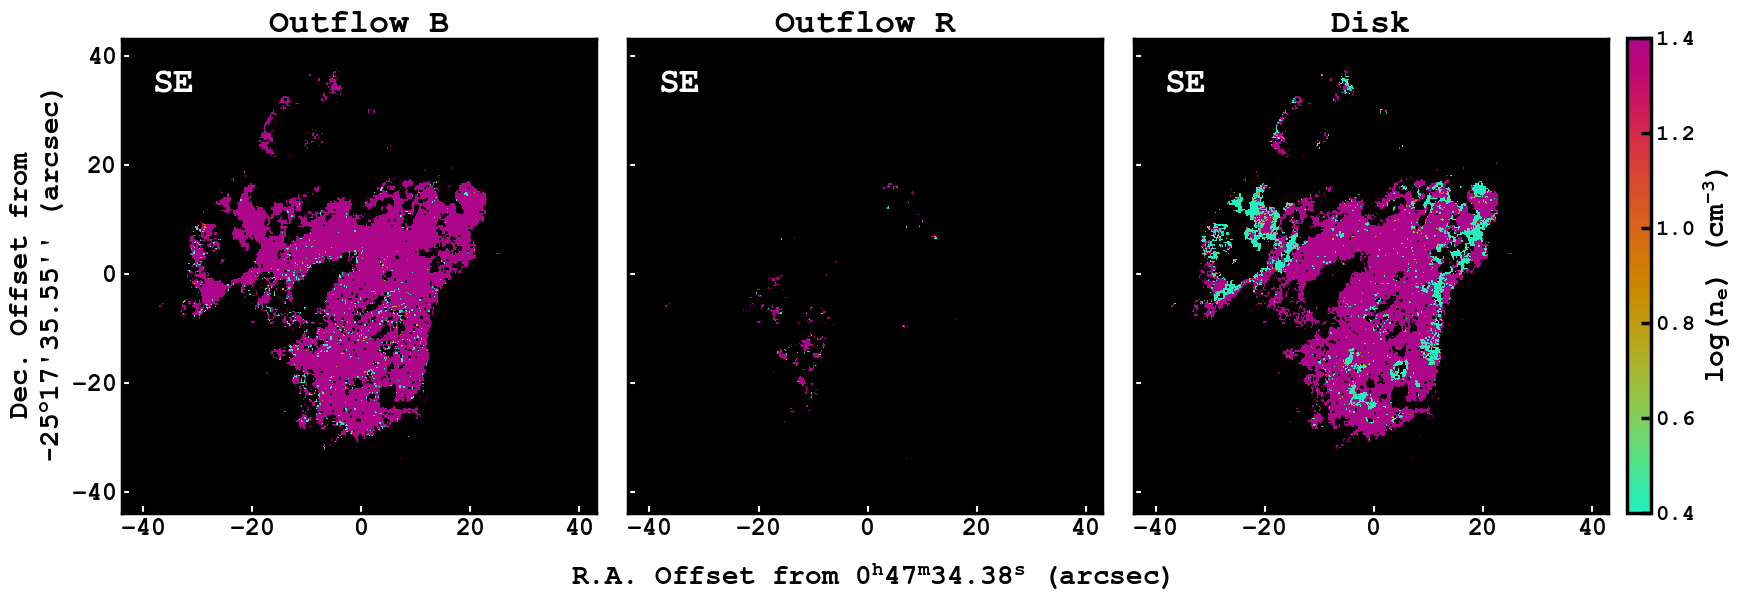

<Figure size 640x480 with 0 Axes>

In [111]:
edens_outb_rat = edens_conversion(siia_flux_outb, siib_flux_outb)
edens_outr_rat = edens_conversion(siia_flux_outr, siib_flux_outb)
edens_disk_rat = edens_conversion(siia_flux_disk, siib_flux_outb)

make_plots(edens_outb_rat, edens_outr_rat, edens_disk_rat, 
           vmin = 0.4, 
           vmax = 1.4, 
           line_label = None, 
           cbar_label = 'log(n$_{e}$) (cm$^{-3}$)')

plt.savefig('../../ngc253/muse/visuals/edensity.png',bbox_inches='tight', dpi=200)
plt.show()